# Import Libraries

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

tf.config.set_visible_devices([], 'GPU')


2025-07-21 16:14:21.554455: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 16:14:22.039483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753085662.233753  197253 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753085662.282098  197253 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753085662.686364  197253 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Exploratory Data Analysis

In [3]:
ROOT = "../../datasets_all2/"
SEED = 88
IMG_SIZE = (150, 150)    # load at original size first
BATCH_SIZE = 128
LABEL_MODE = "categorical" # one‑hot labels straight away
AUTOTUNE = tf.data.AUTOTUNE

label_map={
    "broccoli":[1,0],
    "cauliflower":[0,1],
    "unknown":[0,0]
}
classes=["broccoli", "cauliflower","unknown"]
splits=["test", "train", "validate"]
def data_generator(split):
    for class_name in label_map.keys():
        class_dir = os.path.join(ROOT, split, class_name)
        print(class_name)
        for fname in os.listdir(class_dir):
            img_path = os.path.join(class_dir, fname)
            
            yield img_path, label_map[class_name]


def process(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return img, label


train_ds_pre = tf.data.Dataset.from_generator(
    lambda: data_generator("train"),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(2,), dtype=tf.float32)
    )
)
train_ds_pre = train_ds_pre.map(process, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000,SEED).batch(BATCH_SIZE)

val_ds_pre = tf.data.Dataset.from_generator(
    (lambda: data_generator("validate")),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(2,), dtype=tf.float32)
    )
)
val_ds_pre = val_ds_pre.map(process, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000,SEED).batch(BATCH_SIZE)

test_ds_pre = tf.data.Dataset.from_generator(
    (lambda: data_generator("test")),
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(2,), dtype=tf.float32)
    )
)
test_ds_pre = test_ds_pre.map(process, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000,SEED).batch(BATCH_SIZE)



,broccoli,cauliflower,unknown,splits total
test,257,272,232,761
train,2163,2191,1858,6212
validate,257,271,232,760
img total,2677,2734,2322,7733


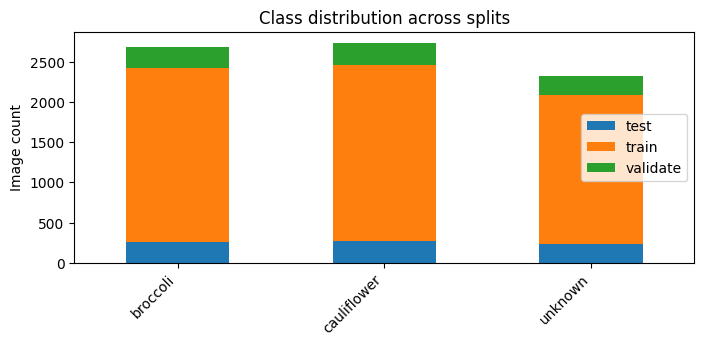

In [4]:
def count_images(split):
    return {cls: len(os.listdir(f"{ROOT}{split}/{cls}/"))
            for cls in classes}

df_counts = pd.DataFrame({s: count_images(s) for s in splits})

table_df = df_counts.T
table_df["splits total"] = table_df.sum(1)
table_df.loc["img total"] = table_df.sum(0)

display(table_df)  # Jupyter table

ax = df_counts.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.show()

broccoli


2025-07-21 16:14:30.682862: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


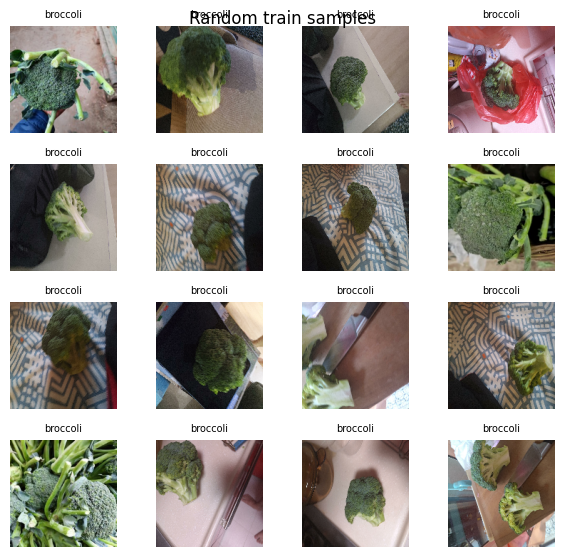

In [5]:
plt.figure(figsize=(6,6))
for images, labels in train_ds_pre.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow((images[i].numpy()).astype("uint8"))
        innertext="unknown"
        if (labels[i][1]):
            innertext="cauliflour"
        elif (labels[i][0]):
            innertext="broccoli"
        
        plt.title(innertext, fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [6]:
TARGET_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom((0.3), 0.3),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds

train_ds = prepare(train_ds_pre, shuffle=True, augment=True)
val_ds = prepare(val_ds_pre)
test_ds = prepare(test_ds_pre)
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)


broccoli
cauliflower
unknown


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2025-07-21 16:14:41.566985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 31 of 1000
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS pa

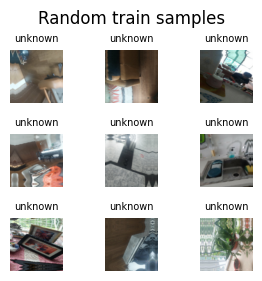

In [7]:
plt.figure(figsize=(3,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        innertext="unknown"
        if (labels[i][1]):
            innertext="cauliflour"
        elif (labels[i][0]):
            innertext="broccoli"
        plt.title(innertext, fontsize=7)
        plt.axis("off")

plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Model building

In [8]:
num_classes = 2

model = keras.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(*IMG_SIZE, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2, activation='sigmoid'))  # 2 outputs for multi-label
model.summary()

Optimizer = optimizers.Adam(0.001)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=Optimizer,
    metrics=[
        'binary_accuracy'
    ]
)

/home/me/anaconda3/envs/HELP/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,403,458 (20.61 MB)

 Trainable params: 5,402,754 (20.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
history = model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    batch_size=BATCH_SIZE,
    validation_data = val_ds,
    callbacks=[early_stop]
)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


model.save_weights('model.weights.h5')
tf.keras.models.save_model(model,'model.keras')

Epoch 1/50
     49/Unknown 68s 1s/step - binary_accuracy: 0.7621 - loss: 0.4995

/home/me/anaconda3/envs/HELP/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.7616 - loss: 0.5002 - val_binary_accuracy: 0.5882 - val_loss: 0.8224
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.7736 - loss: 0.4883 - val_binary_accuracy: 0.6382 - val_loss: 0.7171
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.7361 - loss: 0.5315 - val_binary_accuracy: 0.5526 - val_loss: 1.1112
Epoch 4/50


2025-07-21 16:23:07.563302: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.7642 - loss: 0.4985 - val_binary_accuracy: 0.6783 - val_loss: 0.6256
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.7805 - loss: 0.4698 - val_binary_accuracy: 0.7092 - val_loss: 0.6258
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.7942 - loss: 0.4388 - val_binary_accuracy: 0.8072 - val_loss: 0.3862
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.7988 - loss: 0.4332 - val_binary_accuracy: 0.8533 - val_loss: 0.4086
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.8421 - loss: 0.3844 - val_binary_accuracy: 0.8717 - val_loss: 0.3246
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.8502 - loss: 0.3545 - val_binary_accuracy: 0.8941 - val_loss: 0.2841
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.8740 - loss: 0.3241 - val_binary_accuracy: 0.8368 - val_loss: 0.4956
Epoch 11/50
49/49 ━━━━━━━━━━━━

2025-07-21 16:32:17.691489: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.8097 - loss: 0.4095 - val_binary_accuracy: 0.9296 - val_loss: 0.2557
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.8787 - loss: 0.3123 - val_binary_accuracy: 0.6059 - val_loss: 1.0251
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - binary_accuracy: 0.8470 - loss: 0.3442 - val_binary_accuracy: 0.8822 - val_loss: 0.2602
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - binary_accuracy: 0.8465 - loss: 0.3532 - val_binary_accuracy: 0.9349 - val_loss: 0.1903
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - binary_accuracy: 0.8566 - loss: 0.3346 - val_binary_accuracy: 0.9243 - val_loss: 0.2331
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - binary_accuracy: 0.8649 - loss: 0.3245 - val_binary_accuracy: 0.8559 - val_loss: 0.3426
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - binary_accuracy: 0.8951 - loss: 0.2766 - val_binary_accuracy: 0.9289 - val_loss: 0.2647
Epoch 19/50
49/49 ━━━━━━━

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


Test loss: 0.19398508965969086
Test accuracy: 0.9349539875984192


# Model Evalutation

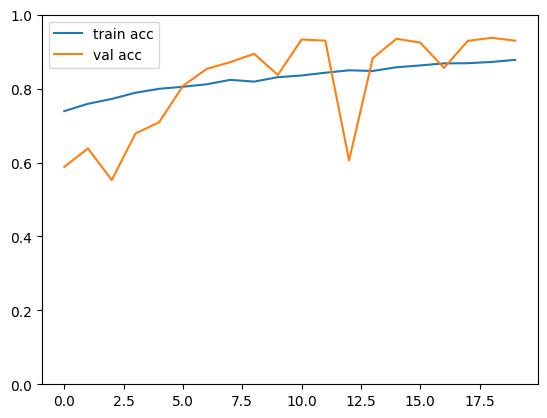

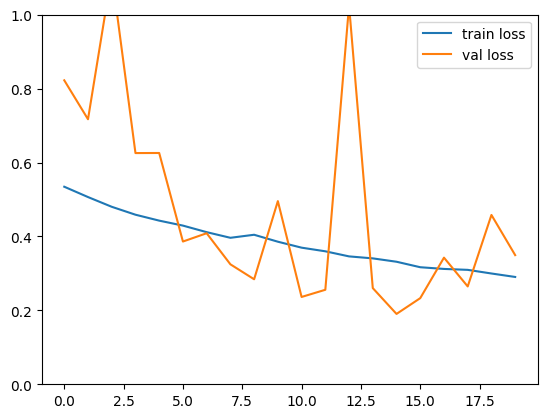

In [13]:

pd.DataFrame(history.history).to_csv("hist.csv", index=False)
plt.ylim(0,1)
plt.plot(history.history['binary_accuracy'], label='train acc')
plt.plot(history.history['val_binary_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.ylim(0,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

broccoli
cauliflower
unknown


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Broccoli Precision:  0.9263803680981595
Broccoli Recall :  0.9956043956043956

Cauliflower Precision:  0.9926470588235294
Cauliflower Recall:  0.8823529411764706


TypeError: 2 must be a sequence

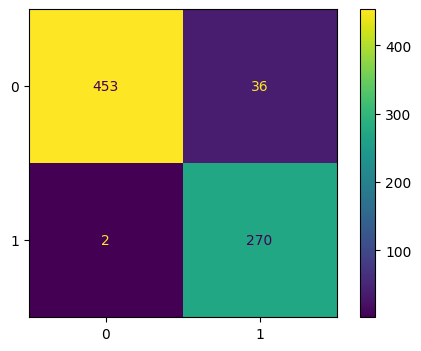

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = tf.keras.models.load_model('./model.keras')

y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))

correct_labels = np.argmax(tf.concat([item for item in y_true], axis = 0), axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

cm = confusion_matrix(correct_labels, predicted_labels)
print("Broccoli Precision: ", cm[0][0] / cm[0].sum())
print("Broccoli Recall : ", cm[0][0] / cm.T[0].sum())
print()
print("Cauliflower Precision: ", cm[1][1] / cm[1].sum())
print("Cauliflower Recall: ", cm[1][1] / cm.T[1].sum())
# print()
# print("Unknown Precision: ", cm[2][2] / cm[2].sum())
# print("Unknown Recall: ", cm[2][2] / cm.T[2].sum())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=num_classes)
fig, ax = plt.subplots(figsize=(6, 4))
disp.plot(ax=ax)
plt.title('Confusion Matrix: Broccoli vs Cauliflower vs Unknown')
plt.tight_layout()
plt.show()